# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Here we init our own modules for DQN learning

In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [4]:
env = UnityEnvironment(file_name=".\Banana_Windows_x86_64\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [28]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

n_test = 10
i_test = 0
while i_test < n_test:
    i_test += 1
    
    action = np.random.randint(action_size)        # select an action
    
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

1 <class 'int'>
0 <class 'int'>
3 <class 'int'>
1 <class 'int'>
1 <class 'int'>
1 <class 'int'>
3 <class 'int'>
1 <class 'int'>
1 <class 'int'>
0 <class 'int'>
Score: 0.0


## Init DQN Agent + See him untrained, in action

First we start off be creating an agent instance

Reading the parameters above, we have the following environment info:
- State Size: 37 dimension
- Action Size: 4 (forward `0`, backward `1`, left `2`, right `3`)
- Task type: Episodic

In [7]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=1337)

In [8]:
def act_in_environment(env, brain_name, action):
    """ Perform action in env & receive (R, S', done)
        > Makes the training code cleaner
    """
    # send the action to the environment
    env_info = env.step(action)[brain_name]        

    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    
    return next_state, reward, done

Let's make the untrained agent do his thing in the environment

In [9]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

n_test = 20
i_test = 0

while i_test < n_test:
    i_test += 1
    
    action = agent.act(state) # select action [by agent]
    
    # [environemnt feedback]
    next_state, reward, done = act_in_environment(env, brain_name, action)
    
    # [3D people look at the scores / rewards]
    score += reward # update the score
    state = next_state # roll over the state to next time step
    if done: # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


As we can see, the agent spins in circles (perpetually presses `LEFT`).
Time to train it!

## Train Agent with DQN

Below we define the agent (DQN-based) training function

In [10]:
def train_dqn(n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """ DEEP Q-LEARNING
    
    Core Training Parameters
        n_episodes: maximum # of training episodes
        max_t: maximum # of timesteps per episode
    
    Episolon-Hyperparameters - Used for Epsilon-Greedy action selection
        Signifies the probability of randomly selecting action (risk for error) vs choosing greedy action (biggest reward)
        
        Epsilon of 1.0 = 100% odds of choosing random action (act of exploration - maybe errorful)
        Epsilon of 0.0 = 0% of choosing random, aka going for optimal action (action which returns biggest reward)
        
        eps_start: starting value for epsilon
        eps_end: min value for epsilon
        eps_decay: epsilon decay factor per episode
    
    """
    
    # init inter-episode variables
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    # train for n_episodes
    for i_episode in range(1, n_episodes+1):
        
        # reset environment & reset score
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]  
        score = 0
        
        # for every episodic task (taking max_t time steps)
        for t in range(max_t):
            
            # 1. select action [by agent]
            action = agent.act(state, eps) 
    
            # 2. get environment feedback
            next_state, reward, done = act_in_environment(env, brain_name, action)
    
            # 3. inform agent on environment feedback
            agent.step(state, action, reward, next_state, done)
        
            # 4. cycle variables & collect reward
            state = next_state
            score += reward
            
            # 5. stop episode if we're done
            if done:
                break
                
        # Perform scoring [save most recent score]
        scores_window.append(score)
        scores.append(score)
        
        # decay epsilon (gradually focus more on learned experience)
        eps = max(eps_end, eps_decay*eps)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=16.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnn_local.state_dict(), 'checkpoint.pth')
            break
        
    return scores

Let's train the agent!

In [64]:
scores = train_dqn()

Episode 100	Average Score: 1.67
Episode 200	Average Score: 6.44
Episode 300	Average Score: 8.93
Episode 400	Average Score: 10.66
Episode 500	Average Score: 11.79
Episode 600	Average Score: 12.36
Episode 700	Average Score: 13.81
Episode 800	Average Score: 13.18
Episode 900	Average Score: 15.45
Episode 997	Average Score: 16.02
Environment solved in 897 episodes!	Average Score: 16.02


and plot the scores for more visual feedback

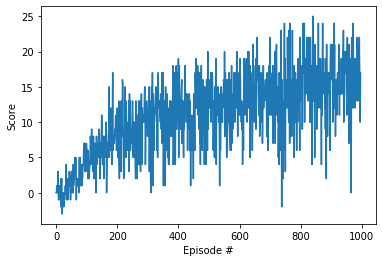

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Watch Smart Agent (load trained weights) & run for 100 eps

Load weights from `checkpoint.pth` and see the agent go!

In [17]:
# load the weights from file
agent.qnn_local.load_state_dict(torch.load('checkpoint.pth'))

# reset the environment
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0] # get the current state

score = 0 # init score
scores = []

n_episode_run = 3

# run for 3 episodes
for i in range(n_episode_run):
    
    try: 
        while True:

            # 1. select action [by agent]
            action = agent.act(state)

            # 2. get environment feedback|
            next_state, reward, done = act_in_environment(env, brain_name, action)

            # 3. Score agent [3D people look at the agent and scoring him]
            score += reward # update the score
            state = next_state # roll-over the state to next time step
            if done: # exit loop if episode finished
                break
        
    except Exception as e: # somehow unity triggers an exception on episode end... so be it!
        # keep scoring
        scores.append(score)
        
        # reset env & more
        score = 0
        env_info = env.reset(train_mode=False)[brain_name] 
        state = env_info.vector_observations[0] # get the new resetted state
        
        continue
    
print("Mean score over {} episodes: {}".format(n_episode_run, np.mean(score)))

Finished episode; current score 18.0
Mean score over 3 episodes: 12.0


When finished, we can close the environment.

In [ ]:
env.close()